In [3]:
from __future__ import division
import numpy as np
import pandas as pd
import numpy.random as rd
import tarfile, sys, os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

sns.set(style="darkgrid", palette="muted", color_codes=True) 
    
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from IPython.display import Image
from sklearn.externals.six import StringIO  
import pydot 
from scipy import ndimage
from six.moves.urllib.request import urlretrieve

/Users/matsuken/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
def generate_cmap(colors):
    """自分で定義したカラーマップを返す"""
    values = range(len(colors))
    
    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

### ジニ係数


$$\mathcal{I}(t) = \sum_{i\neq j}P(C_i|t)P(C_j|t) =  \sum_{i=1}^K P(C_i|t)(1-P(C_i|t))$$


$$\mathcal{I}(t) = 1 - \sum_{i=1}^K P(C_i|t)^2$$

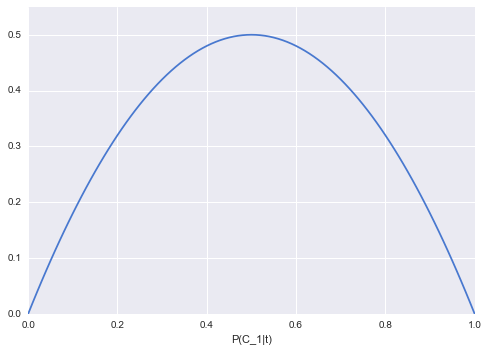

In [4]:
p1 = np.linspace(0,1,101)
p2 = 1 - p1
I  = 1 - p1**2 - p2**2

plt.ylim(0, 0.55)
plt.plot(p1,I)
plt.xlabel('P(C_1|t)')


In [5]:
cm = generate_cmap(['salmon', 'salmon', 'salmon', 'lightblue', 'blue', 'blue', 'blue', 'blue'])

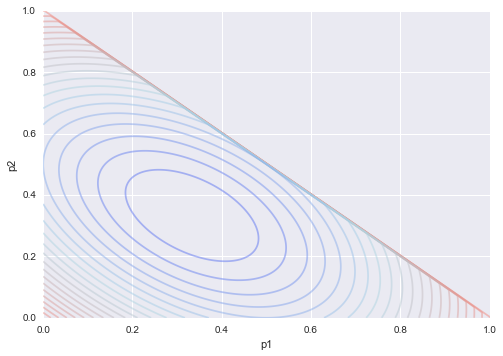

In [6]:
def gini_3class(X, Y):
    ret_list = []
    for x, y in zip(X, Y):    
        if x + y > 1: 
            ret_list.append(0)
            continue
        z = (1-x-y)
        ret_list.append(1-x**2 - y**2 - z**2)
    return np.array(ret_list)

n = 301
X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
Z = gini_3class(X.flatten(), Y.flatten()).reshape(n, n)

interval = [i/30. -1 for i in range(100)]
im = plt.contour(X, Y, Z, interval, alpha=0.5, cmap=cm)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('p1')
plt.ylabel('p2')

|axis|value|ratio_l|gini_l|ratio_r|gini_r|gini dalta|
|:-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|x|1.8|0.111|0.000 |0.889|0.469 |0.417|
|x|2.45|0.222|0.000 |0.778|0.408 |0.317|
|x|3.0|0.333|0.000 |0.667|0.278 |0.185|
|x|4.2|0.444|0.375 |0.556|0.320 |0.344|
|x|5.75|0.556|0.480 |0.444|0.375 |0.433|
|x|6.8|0.667|0.444 |0.333|0.000 |0.296|
|x|7.9|0.778|0.490 |0.222|0.000 |0.381|
|x|8.85|0.889|0.500 |0.111|0.000 |0.444|
|y|1.05|0.111|0.000 |0.889|0.469 |0.417|
|y|1.85|0.222|0.500 |0.778|0.490 |0.492|
|y|2.6|0.333|0.444 |0.667|0.444 |0.444|
|y|3.6|0.444|0.375 |0.556|0.320 |0.344|
|y|4.8|0.556|0.480 |0.444|0.375 |0.433|
|y|5.95|0.667|0.500 |0.333|0.444 |0.481|
|y|6.65|0.778|0.490 |0.222|0.000 |0.381|
|y|7.5|0.889|0.500 |0.111|0.000 |0.444|
min_gini: 0.185185185185
min_val: x 3.0


(0, 10)

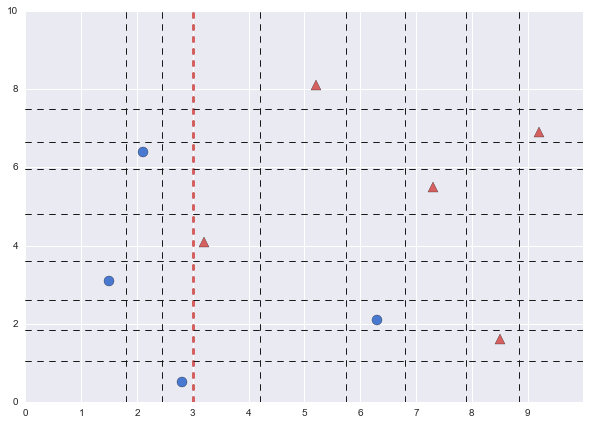

In [7]:
# テストデータの作成
class1 = np.array([[1.5, 3.1], [2.1, 6.4], [2.8, 0.5], [6.3, 2.1]])
class2 = np.array([[3.2, 4.1], [5.2, 8.1], [7.3, 5.5], [8.5, 1.6], [9.2, 6.9]])
all_data = np.r_[class1, class2]
N = len(all_data)
x_sorted = np.sort(all_data[:,0])
y_sorted = np.sort(all_data[:,1])

xx = [(x_sorted[i+1] + x_sorted[i])/2 for i in range(len(x_sorted)-1)]
yy = [(y_sorted[i+1] + y_sorted[i])/2 for i in range(len(y_sorted)-1)]

# ----------------------------------------
plt.figure(figsize=(10,7))

for data, col, marker in zip([class1, class2], 'br', 'o^'):
    plt.scatter(data[:,0], data[:,1], c=col, marker=marker, s=100)
    
min_gini = 1
axis = ''
min_val  = 0

print "|axis|value|ratio_l|gini_l|ratio_r|gini_r|gini dalta|"
print "|:-----:|-----:|-----:|-----:|-----:|-----:|-----:|"

# x_1軸での分割
for x in xx:
    plt.plot([x, x], [0, 10], 'k--', lw=1)
    
    # 分割の左側の個数(クラスごと、合計の数)
    n_c1_l = np.sum(class1[:,0] < x)
    n_c2_l = np.sum(class2[:,0] < x)
    n_l    = n_c1_l + n_c2_l
    
    # 分割した左側のgini係数
    gini_l = 1 - (n_c1_l/n_l)**2 - (n_c2_l/n_l)**2
    
    # 分割の右側の個数(クラスごと、合計の数)
    n_c1_r = np.sum(class1[:,0] >= x)
    n_c2_r = np.sum(class2[:,0] >= x)
    n_r    = n_c1_r + n_c2_r
    
    # 分割した右側のgini係数
    gini_r = 1 - (n_c1_r/n_r)**2 - (n_c2_r/n_r)**2
    
    # 左右合わせた平均gini係数
    ratio_l = n_l/(n_l+n_r)
    ratio_r = 1 - ratio_l
    ave_gini = ratio_l*gini_l + ratio_r*gini_r
      
    #print "|x:{0} | ratio_l:{1:.3f} | ratio_r:{2:.3f} | gini dalta:{3:.3f}|".format(
    print "|x|{0}|{1:.3f}|{2:.3f} |{3:.3f}|{4:.3f} |{5:.3f}|".format(
           x, ratio_l,gini_l, ratio_r,gini_r, ave_gini)
    
    # 平均gini係数が最小であれば保管しておく
    if min_gini > ave_gini:
        min_gini = ave_gini 
        min_val = x
        axis = 'x'
    
    
for y in yy:
    plt.plot([0, 10], [y, y], 'k--', lw=1)
    
    # 分割の下側の個数(クラスごと、合計の数)
    n_c1_l = np.sum(class1[:,1] < y)
    n_c2_l = np.sum(class2[:,1] < y)
    n_l    = n_c1_l + n_c2_l
    
    # 分割した下側のgini係数
    gini_l = 1 - (n_c1_l/n_l)**2 - (n_c2_l/n_l)**2
    
    # 分割の上側の個数(クラスごと、合計の数)
    n_c1_r = np.sum(class1[:,1] >= y)
    n_c2_r = np.sum(class2[:,1] >= y)
    n_r    = n_c1_r + n_c2_r
    
    # 分割した上側のgini係数
    gini_r = 1 - (n_c1_r/n_r)**2 - (n_c2_r/n_r)**2
    
    # 左右合わせた平均gini係数
    ratio_l = n_l/(n_l+n_r)
    ratio_r = 1 - ratio_l
    ave_gini = ratio_l*gini_l + ratio_r*gini_r
    
    #print "|y:{0} | ratio_l:{1:.3f} | ratio_r:{2:.3f} | gini dalta:{3:.3f}|".format(
    print "|y|{0}|{1:.3f}|{2:.3f} |{3:.3f}|{4:.3f} |{5:.3f}|".format(
           y, ratio_l,gini_l, ratio_r,gini_r, ave_gini)

    # 平均gini係数が最小であれば保管しておく
    if min_gini > ave_gini:
        min_gini = ave_gini
        min_val = y
        axis = 'y'

print "min_gini:", min_gini
print "min_val:", axis, min_val

# 分割線の描画(最良の分割を赤い線で描画)
for x in xx:
    if axis == 'x' and x == min_val:
        plt.plot([x, x], [0, 10], 'r--', lw=3)  
    else:
        plt.plot([x, x], [0, 10], 'k--', lw=1)     
    
for y in yy:
    if axis == 'y' and y == min_val:
        plt.plot([0, 10], [y, y], 'r--', lw=3) 
    else:
        plt.plot([0, 10], [y, y], 'k--', lw=1)
        
    
plt.xticks(range(10))
plt.xlim(0,10)
plt.ylim(0,10)

### 決定木による分類

In [5]:
print 'fetch MNIST dataset'
mnist = fetch_mldata('MNIST original')
# mnist.data : 70,000件の784次元ベクトルデータ
mnist.data   = mnist.data.astype(np.float32)
mnist.data  /= 255     # 0-1のデータに変換

# mnist.target : 正解データ（教師データ）
mnist.target = mnist.target.astype(np.int32)

fetch MNIST dataset


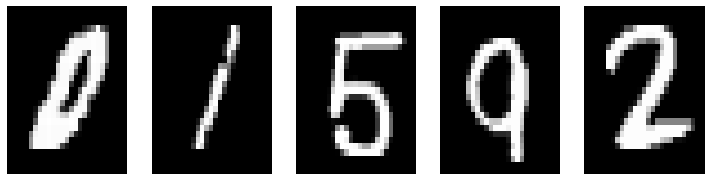

In [6]:
# 手書き数字データを描画する関数
def draw_digit(digits):
    size = 28
    plt.figure(figsize=(len(digits)*2.5, 3))
    for i, data in enumerate(digits):
        plt.subplot(1, len(digits), i+1)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]             # flip vertical
        plt.xlim(0,27)
        plt.ylim(0,27)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")

    plt.show()

draw_digit([mnist.data[71], mnist.data[12345], mnist.data[33456], mnist.data[59187], mnist.data[12952], ])

In [10]:
# 学習用データを N個、検証用データを残りの個数と設定
N = 60000
x_train, x_test = np.split(mnist.data,   [N])
y_train, y_test = np.split(mnist.target, [N])


In [16]:
#　精度確認
def confirm_result(clf, x_data, y_data):
    pred = clf.predict(x_data)
    print "confusion matrix"
    print confusion_matrix(y_data, pred)
    print ""
    print "classification report"
    print classification_report(y_data, pred, target_names=map(str, range(10)))
    print ""
    print "accuracy"
    print accuracy_score(y_data, pred)

In [20]:
# 決定木によるモデル構築
clf_dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best')
clf_dt = clf_dt.fit(x_train, y_train)

In [21]:
#　訓練データでの精度確認
print "train"
confirm_result(clf_dt, x_train, y_train)

train
confusion matrix
[[5923    0    0    0    0    0    0    0    0    0]
 [   0 6742    0    0    0    0    0    0    0    0]
 [   0    0 5958    0    0    0    0    0    0    0]
 [   0    0    0 6131    0    0    0    0    0    0]
 [   0    0    0    0 5842    0    0    0    0    0]
 [   0    0    0    0    0 5421    0    0    0    0]
 [   0    0    0    0    0    0 5918    0    0    0]
 [   0    0    0    0    0    0    0 6265    0    0]
 [   0    0    0    0    0    0    0    0 5851    0]
 [   0    0    0    0    0    0    0    0    0 5949]]

classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      591

In [22]:
#　検証データでの精度確認
print "test"
confirm_result(clf_dt, x_test, y_test)

test
confusion matrix
[[ 920    0   12    8    2   10   10    3    9    6]
 [   1 1092    9    2    2    6    6    3   13    1]
 [  11   11  891   27   15    7   11   25   25    9]
 [   6    5   32  852    6   48    2   14   26   19]
 [   4    5    8    8  868    9   15    7   19   39]
 [  15    7    2   49    5  744   26    4   23   17]
 [  21    5   10    7   18   23  845    1   21    7]
 [   3   11   23   11    4    5    4  929   13   25]
 [  12    7   24   42   24   25   20    9  788   23]
 [  14    5    8   21   41   11    7   21   22  859]]

classification report
             precision    recall  f1-score   support

          0       0.91      0.94      0.93       980
          1       0.95      0.96      0.96      1135
          2       0.87      0.86      0.87      1032
          3       0.83      0.84      0.84      1010
          4       0.88      0.88      0.88       982
          5       0.84      0.83      0.84       892
          6       0.89      0.88      0.89       958

In [24]:
# 木構造の可視化
dot_data = StringIO() 
export_graphviz(clf_dt, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("mnist_graph.pdf") 

True

### Random Forestによる分類

In [11]:
# Random Forestによるモデル構築
clf = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=None, min_samples_split=2, 
                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', 
                       max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=2, 
                       random_state=None, verbose=0, warm_start=False, class_weight=None)
clf = clf.fit(x_train, y_train)

In [17]:
#　訓練データでの精度確認
print "train"
confirm_result(clf, x_train, y_train)

train
confusion matrix
[[5923    0    0    0    0    0    0    0    0    0]
 [   0 6741    0    0    0    0    0    1    0    0]
 [   0    0 5958    0    0    0    0    0    0    0]
 [   0    0    0 6131    0    0    0    0    0    0]
 [   0    0    0    0 5842    0    0    0    0    0]
 [   0    0    0    0    0 5421    0    0    0    0]
 [   0    0    0    0    0    0 5918    0    0    0]
 [   0    0    0    0    0    0    0 6265    0    0]
 [   0    0    0    0    0    0    0    0 5851    0]
 [   0    0    0    0    0    0    0    0    0 5949]]

classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      591

In [18]:
#　検証データでの精度確認
print "test"
confirm_result(clf, x_test, y_test)

test
confusion matrix
[[ 969    0    2    0    0    2    3    1    3    0]
 [   0 1122    3    3    1    1    2    0    3    0]
 [   5    0  999    6    2    0    4    9    7    0]
 [   1    0   10  973    0    7    0    8    8    3]
 [   1    0    1    0  947    0    7    0    4   22]
 [   4    2    1   14    3  854    5    1    7    1]
 [   6    3    1    0    3    5  936    0    4    0]
 [   1    3   20    2    3    0    0  989    3    7]
 [   5    0    5    8    5    7    4    4  929    7]
 [   7    6    3   12   15    3    1    5    4  953]]

classification report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       980
          1       0.99      0.99      0.99      1135
          2       0.96      0.97      0.96      1032
          3       0.96      0.96      0.96      1010
          4       0.97      0.96      0.97       982
          5       0.97      0.96      0.96       892
          6       0.97      0.98      0.97       958

In [25]:
# 弱学習器の可視化
dot_data = StringIO() 
export_graphviz(clf.estimators_[0], out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("mnist_graph_rf.pdf") 

True